<a href="https://colab.research.google.com/github/OlegKuzmin1968/Oleg_Kuzmin/blob/main/%D0%97%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BF%D0%B8%D0%BA%D1%81%D0%B5%D0%BB%D0%B5%D0%B9_%D0%B2_%D0%B7%D0%BE%D0%BD%D0%B5_%D0%BF%D0%BE%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_NII_DICOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Стажировка

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#*Сопостовление в Python файла NII(nifti) с сегментацией выпота и DICOM-файла*
Цель: получить спектр значений пикселей оригинального снимка в пораженной области (взять из сегментации).

# Загрузка

In [60]:
from nibabel.viewers import OrthoSlicer3D
from nibabel import nifti1
import nibabel as nib
from matplotlib import pylab as plt
import matplotlib
import numpy as np
from matplotlib import pyplot, cm
import os
from PIL import Image # Синтаксис и описание функции Image.open():
import cv2

# Сегментация плеврального выпота (NIfTI)

Файл из предоставленного заказчиком Data Seta

**Pleural Effusion Segmentations (NIfTI, 1.7 MB zip)**

     - PleThora Effusions June 2020

        - Effusions

           - LUNG1-420

             - LUNG1-420_effusion_third_reviewer.nii.gz   # Загружаем этот файл

                    - LUNG1-420_effusion_third_reviewer.nii

## Читаем информацию и выводим несколько изображений из файла ххх/nii.gz

что это?  <class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 176)
affine: 
[[  -0.9765625    -0.            0.          249.51170349]
 [  -0.            0.9765625    -0.         -249.51173401]
 [   0.            0.            3.         -791.90002441]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 176   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.9765625  0.9765625  3.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
c

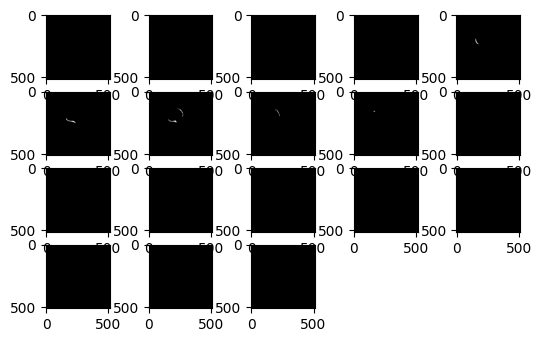

In [5]:
# Разместил файл у себя на Google диске
# Укажим путь и имя файла nii.gz, который хотим посмотреть
# example_filename = '/content/drive/MyDrive/Stag/LUNG1-420_effusion_third_reviewer.nii.gz'

#  **** Скачиваем файл пациента LUNG1-093 в формате .nii.gz  ****
example_filename = '/content/drive/MyDrive/Baza/Stag_1/Effusions/LUNG1-093/LUNG1-093_effusion_first_reviewer.nii.gz'
img_eff = nib.load(example_filename)     # Загружаем файл в переменную


 # Смотрим что загрузили
print('что это? ', img_eff, '\n' )                   # выдаем много информации
print('смотрим размерность img_eff', img_eff.shape)  # смотрим размерность
print('это:  ', img_eff.dataobj.shape)               # смотрим размерность

 # Печатаем только три параметра размерности
width, height, queue = img_eff.dataobj.shape
print('width', width)
print('height', height)
print('queue', queue)

# Показать 3D -изображение
# OrthoSlicer3D(img.dataobj).show()  # выводит пустое окно ???


 # Рассчет, количества окон на экране для размещения всех срезов
x = int((queue/10) ** 0.5) + 1   # выводим каждый 10-й слайс
num = 1                          # порядковый номер картинки

 # Выводим в цикле каждый 10-й слайс, из всех имеющихся queue. Отображаем 2D -изображение.
for i in range(0, queue, 10):
  img_arr_eff = img_eff.dataobj[:, :, i]
  plt.subplot(x, x, num)
  plt.imshow(img_arr_eff, cmap='gray')
  num += 1


plt.show()

In [6]:
type (img_eff)

nibabel.nifti1.Nifti1Image

## Выводим один из слайсов файла ххх/nii.gz

Размер переменной eff.shape (512, 512)


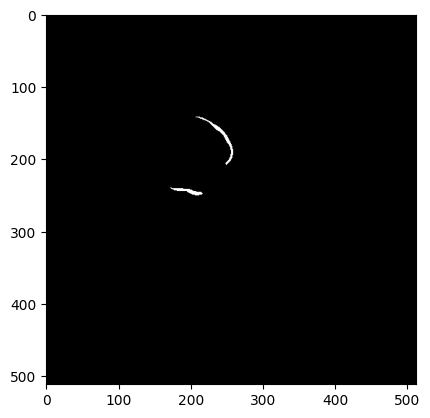

In [7]:
eff = img_eff.dataobj[:,:,64]                         # вытаскиваем из img - переменной, которая содержит 176 слайса, один 64
print('Размер переменной eff.shape', eff.shape)

plt.imshow (eff, cmap='gray')
plt.show()

## Преобразуем  **class 'nibabel.nifti1.Nifti1Image'** в np-массив

In [62]:
print('Тип переменной одного слайса -',type (eff))
print('Переводим его в np-массив')
np_eff = np.array (eff)
print('Новый тип переменной', type(np_eff), 'Размерность', np_eff.shape)

Тип переменной одного слайса - <class 'numpy.ndarray'>
Переводим его в np-массив
Новый тип переменной <class 'numpy.ndarray'> Размерность (512, 512)


In [10]:
# Добавим размерность для подачи в НС
np_eff3 = np.reshape (np_eff,[1,512,512])
print('Тип переменной-',type(np_eff3), 'Размер-', np_eff3.shape)

Тип переменной- <class 'numpy.ndarray'> Размер- (1, 512, 512)


# Сегментация грудной клетки (NIfTI)

In [11]:
P = 'LUNG1_093' # пациент
slace = 64


## Читаем информацию и выводим несколько изображений из файла ххх/nii/gz

что это?  <class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 176)
affine: 
[[  -0.9765625    -0.            0.          249.51170349]
 [  -0.            0.9765625    -0.         -249.51173401]
 [   0.            0.            3.         -791.90002441]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 176   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.9765625  0.9765625  3.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
c

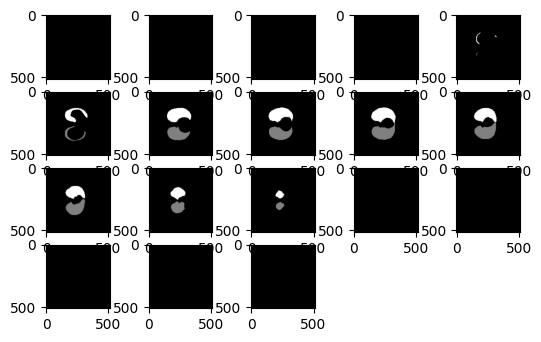

In [12]:
# Разместил файл у себя на Google диске
# Укажим путь и имя файла nii, который хотим посмотреть
thoracic_filename = '/content/drive/MyDrive/Baza/Stag_1/Thoracic_Cavities/LUNG1-093/LUNG1-093_thor_cav_primary_reviewer.nii.gz'
img_thor = nib.load(thoracic_filename)


 # Смотрим что загрузили
print('что это? ', img_thor, '\n')            # выдаем много информации
print('смотрим размерность ', img_thor.shape)  # смотрим размерность
print('это:  ', img_thor.dataobj.shape)        # смотрим размерность

 # Печатаем только три параметра размерности
width, height, queue = img_thor.dataobj.shape
print('width', width)
print('height', height)
print('queue', queue)

 # Показать 3D -изображение
# OrthoSlicer3D(img.dataobj).show()  # выводит пустое окно ???


 # Рассчет, количества окон на экране для размещения всех срезов
x = int((queue/10) ** 0.5) + 1   # выводим каждый 10-й слайс
num = 1                          # порядковый номер картинки

 # Выводим в цикле каждый 10-й слайс, из всех имеющихся queue. Отображаем 2D -изображение.
for i in range(0, queue, 10):
  img_arr_thor = img_thor.dataobj[:, :, i]
  plt.subplot(x, x, num)
  plt.imshow(img_arr_thor, cmap='gray')
  num += 1

plt.show()


In [13]:
type (img_thor)

nibabel.nifti1.Nifti1Image

## Выводим один из слайсов файла ххх/nii

**смотрим 64-й слайс**

Размер переменной w.shape (512, 512)


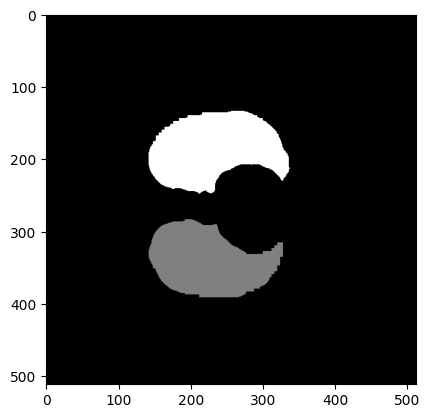

In [14]:
thor = img_thor.dataobj[:,:,64]       # вытаскиваем из img - переменной, которая содержит 134 слайса, один 44
print('Размер переменной w.shape', thor.shape)

plt.imshow (thor, cmap='gray')
plt.show()

## Преобразуем  **class 'nibabel.nifti1.Nifti1Image'** в np-массив

In [15]:
print('Тип переменной одного слайса -',type (thor))
print('Переводим его в np-массив')
np_thor = np.array (thor)
print('Новый тип переменной', type(np_thor), 'Размерность', np_thor.shape)

Тип переменной одного слайса - <class 'numpy.ndarray'>
Переводим его в np-массив
Новый тип переменной <class 'numpy.ndarray'> Размерность (512, 512)


In [16]:
# Добавим размерность для подачи в НС
np_thor3 = np.reshape (np_thor,[1,512,512])
print('Тип переменной-',type(np_thor3), 'Размер-', np_thor3.shape)

Тип переменной- <class 'numpy.ndarray'> Размер- (1, 512, 512)


## Сделаем три среза данных
из разных областей картинки, примерно оценив их координаты. Цель - посмотреть значения пикселя.

In [18]:
# Координаты левого легкого - "серого" участка картинки
print (np_thor3 [0,320:330,200:210])
print('Значение 1 соответствует "серому" цвету на картинке - левое легкое')

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Значение 1 соответствует "серому" цвету на картинке - левое легкое


In [19]:
# Координаты "фона" на картинке
print (np_thor3[0,0:10,0:10])
print('Значение 0 соответствует церному цвету на картинке')

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Значение 0 соответствует церному цвету на картинке


In [20]:
# Координаты правого легкого - "белого" участка картинки
print(np_thor3[0,200:210,200:210])
print('Значение 2 соответствует белому цвету на картинке')

[[2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]]
Значение 2 соответствует белому цвету на картинке



# Работа с оригинальным изображением

### Загрузки библиотек для работы с DICOM

In [21]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00


In [22]:
# Единственный интересный момент здесь заключается в том, как я упоминал в разделе "Пакет pydicom",
# что пакет pydicom импортируется как dicom, поэтому будьте осторожны с этим.

import pydicom           # запустился так
import pydicom.data      # + metod

### Путь к каталогу с файлами DICOM

**базовая версия кода**

In [ ]:
# Вызов локального файла dicom
folder_path = r"D:\Files\Data\Materials"
file_name = "PA1_0001.dcm"
file_path = os.path.join(folder_path,file_name)
ds = pydicom.dcmread(file_path)

**локальная (в моем NB) версия кода**

In [23]:
base = "/content/drive/MyDrive/Baza/Stag_1/Original_Directory/NSCLC-Radiomics/LUNG1_093/04-13-2006-StudyID-NA-25111/0.000000-NA-54643/"
pass_dicom = "1-064.dcm"    # file name
print(pass_dicom)
print(base)

1-064.dcm
/content/drive/MyDrive/Baza/Stag_1/Original_Directory/NSCLC-Radiomics/LUNG1_093/04-13-2006-StudyID-NA-25111/0.000000-NA-54643/


In [24]:
# filename = pydicom.data.data_manager.get_files(base, pass_dicom)[0]
q = pydicom.data.data_manager.get_files (base, pass_dicom)[0]               # разобраться с [0]

In [25]:
print (type (q))
print ('Путь',q)

<class 'str'>
Путь /content/drive/MyDrive/Baza/Stag_1/Original_Directory/NSCLC-Radiomics/LUNG1_093/04-13-2006-StudyID-NA-25111/0.000000-NA-54643/1-064.dcm


### Чтение и отрисовка файла DICOM


 Просмотр изображений DICOM с помощью pydicom и matplotlib

Тип переменной ds (type) -  <class 'pydicom.dataset.FileDataset'>


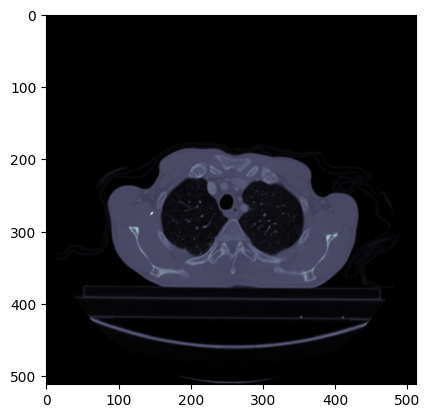

In [26]:
ds = pydicom.dcmread(q)                            # Функция считывает одно изображение и возвращает объект pydicom.dataset.FileDataset
print('Тип переменной ds (type) - ', type (ds))
# enter DICOM image name for pattern
# введите название изображения DICOM для шаблона
# result is a list of 1 element
# результатом является список из 1 элемента
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)       # set the color map to bone

plt.show()

In [27]:
print(ds.PatientID,ds.StudyDate,ds.Modality) # прочитаем значения тегов

LUNG1-093 20060413 CT


In [28]:
ds  # Вопрос 1: как и в какой формат все, что видим ниже вытащить?.  Вопрос 2: что вытаскивать?

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.32722.99.99.167050992359108282518473334633778451615
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.1

### Перевод в np-массив файл DICOM

Используйте Python для чтения и записи файлов Dicom
https://russianblogs.com/article/84851535474/

После чтения файла Dicom вы можете использовать Numpy (data = np.array(ds.pixel_array)

In [30]:
print('Тип переменной исходного слайса ds-',type (ds))
print('Переводим его в np-массив')

np_orig = np.array(ds.pixel_array, dtype = np.int16) # можно изменить размер переменной

print('\n','Новый тип переменной', type(np_orig))
print(' Размерность полученного массива', np_orig.shape)
print(' Размерность переменной', np_orig.dtype )

Тип переменной исходного слайса ds- <class 'pydicom.dataset.FileDataset'>
Переводим его в np-массив

 Новый тип переменной <class 'numpy.ndarray'>
 Размерность полученного массива (512, 512)
 Размерность переменной int16


## Разворот оригинального изображения на 90 и 270 гр.

In [31]:
# Повернем изображение на 90 гр против часовой стрелки
# print("\nRotated array : \n", np.rot90(array))
np_orig90 = np.rot90(np_orig, 1)
np_orig270 = np.rot90(np_orig, 3)

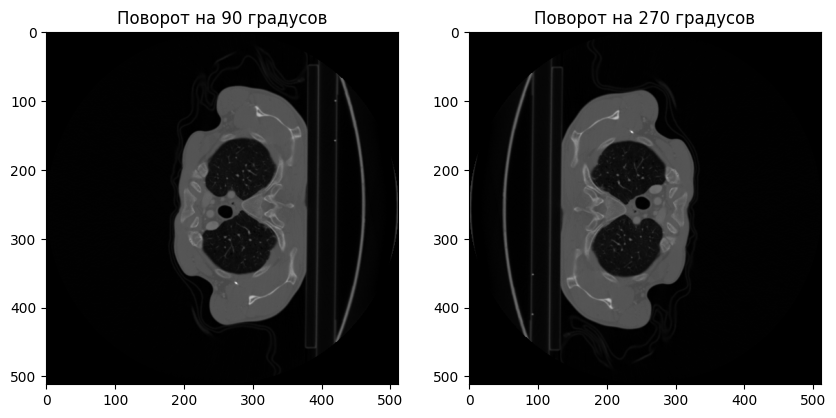

In [32]:
plt.figure(1, figsize=(10,8))

plt.subplot(121) # 1-я позиция -кол-во строк, 2-я позиция кол-во столбцов, 3-я позиция какой по счету этот график
plt.title('Поворот на 90 градусов')
plt.imshow(np_orig90, cmap='gray')

plt.subplot(122) #
plt.title('Поворот на 270 градусов')
plt.imshow (np_orig270, cmap='gray')

plt.show()


plt.show()

# **Анализ оригинального изображения через маску выпота**


## Выведем на экран все три изображения, посмотрим на соответствие координат

**Оригинальное изображение повернуто на 90 градусов**

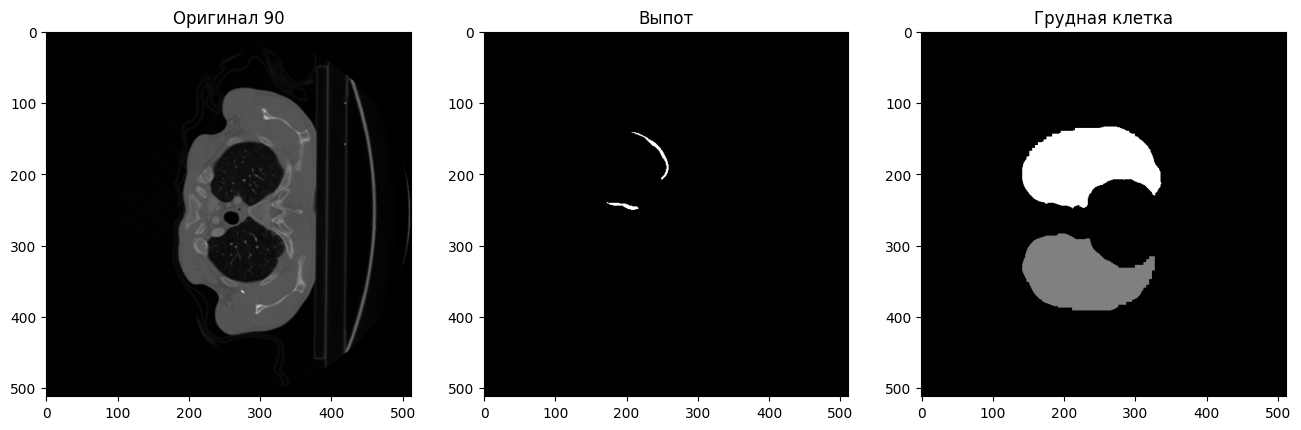

In [33]:
plt.figure(1, figsize=(16,16))

plt.subplot(131) # 1-я позиция -кол-во строк, 2-я позиция кол-во столбцов, 3-я позиция какой по счету этот график
plt.title('Оригинал 90')
plt.imshow(np_orig90, cmap='gray')
plt.subplot(132) # у
plt.title('Выпот')
plt.imshow (np_eff, cmap='gray')
plt.subplot(133) # у
plt.title('Грудная клетка')
plt.imshow (np_thor, cmap='gray')
plt.show()


plt.show()


**Оригинальное изображение повернуто на 270 градусов**

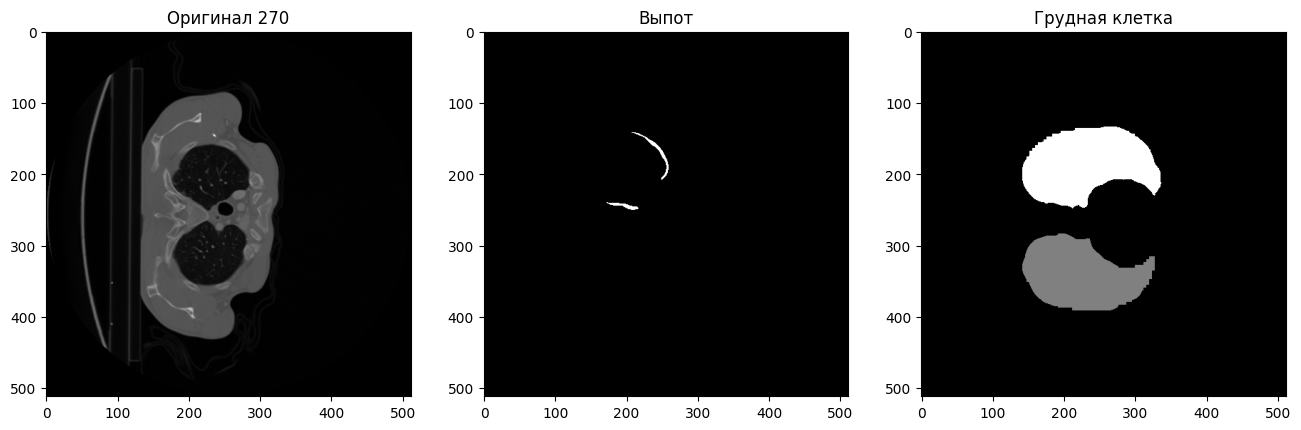

In [34]:
plt.figure(1, figsize=(16,16))

plt.subplot(131) # 1-я позиция -кол-во строк, 2-я позиция кол-во столбцов, 3-я позиция какой по счету этот график
plt.title('Оригинал 270')
plt.imshow(np_orig270, cmap='gray')
plt.subplot(132) # у
plt.title('Выпот')
plt.imshow (np_eff, cmap='gray')
plt.subplot(133) # у
plt.title('Грудная клетка')
plt.imshow (np_thor, cmap='gray')
plt.show()


plt.show()

**При повороте на 270 градусов оригинального изображения получилось сопоставить все три изображения в рамках границ оригинального изображения**

/content/drive/MyDrive/Stag_1/co270j.jpg


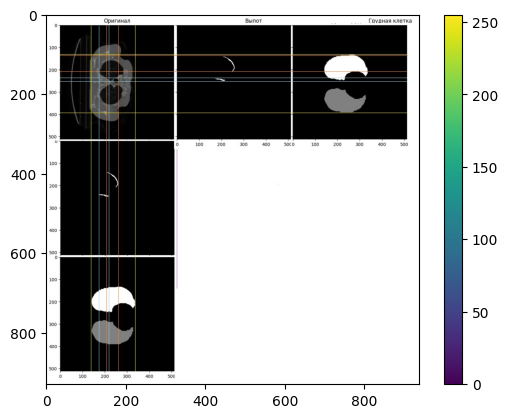

In [59]:
full_path = "/content/drive/MyDrive/Stag_1/co270j.jpg"
print (full_path)
image = cv2.imread(full_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)


## Анализ слайса сегментированного выпота

In [111]:
#  Проведем анализ слайса сегментированного выпота
x_list = []   # список х-координат (диапазон 1-512)
y_list = []   # список у-координат (диапазон 1-512)


for x in range (np_eff.shape[0]):    # запускаем счетчик по координате х
  for y in range (np_eff.shape[1]):  # запускаем счетчик по координате у
    a = np_eff [x,y]                 # значения пикселя в каждой координате присваиваем переменной а
    if a == 1:                       # если а == 1 (признак выпота) записываем координаты в список координат выпота
      x_list.append (x)              #
      y_list.append (y)              #
      #print (y,x)
print('Колчество пикселей выпота на слайсе =',len(x_list))
print('Сравниваем колчество позиций по х-',len(x_list), 'и у-', len(y_list))

Колчество пикселей выпота на слайсе = 486
Сравниваем колчество позиций по х- 486 и у- 486


In [67]:
# Преобразуем списки х и у в np массив и добавим размерность
x_np = np.array (x_list)
x_np = x_np.reshape(len(x_list),1)
print ('x',x_np.shape)

y_np = np.array (y_list)
y_np = y_np.reshape(len(y_list),1)
print ('y',y_np.shape)

x (486, 1)
y (486, 1)


In [68]:
# Соберем координаты всех точек, имеющих признак выпото (по сегментации)
# в 2-у мерный массив со столбцами х-0, у-1
effusion_coordinates = np.append (x_np, y_np, axis=1)
effusion_coordinates # массив с координатами выпота для данного слайса
effusion_coordinates.shape

In [72]:
# Смотрим координаты одной из точек массива
X = effusion_coordinates[10,0]
Y = effusion_coordinates[10,1]
print('X10-',X,'Y10-',Y)

X10- 143 Y10- 215


In [82]:
# Посмотрим диапазон значений пикселей в массиве

print ('Max значение зоны выпота по координате y', np.max(effusion_coordinates[:,1]))
print ('Min значение зоны выпота по координате y', np.min(effusion_coordinates[:,1]))
print ('Max значение зоны выпота по координате x', np.max(effusion_coordinates[:,0]))
print ('Min значение зоны выпота по координате x', np.min(effusion_coordinates[:,0]))
print ('Число элементов в массиве', np.size(effusion_coordinates))
print ('Размерность массива', np.shape (effusion_coordinates))

Max значение зоны выпота по координате y 258
Min значение зоны выпота по координате y 172
Max значение зоны выпота по координате x 250
Min значение зоны выпота по координате x 142
Число элементов в массиве 972
Размерность массива (486, 2)


In [75]:
print('Количество строк массива - пикселей выпота', effusion_coordinates.shape[0])
print('Координата х - n-го пикселей выпота', effusion_coordinates[0,0])
print('Координата у - n-го пикселей выпота', effusion_coordinates[0,1])

Количество строк массива - пикселей выпота 486
Координата х - n-го пикселей выпота 142
Координата у - n-го пикселей выпота 207


**У нас есть массив координат выпота составленный на основе файла сегментированого выпота**

Посмотрим теперь на значения пикселей на оригинальном снимке по этим координатам

In [85]:
n = 17 # порядковый номер пикселя в массиве

print('Значение n-го пикселя на оригинальном снимке с заданными координатами')
print('Координата х', [effusion_coordinates[n,0]])
print('Координата у', [effusion_coordinates[n,1]])
print('Значение пикселя по этим координатам -', np_orig [effusion_coordinates[n,0],effusion_coordinates[n,1]])

Значение n-го пикселя на оригинальном снимке с заданными координатами
Координата х [144]
Координата у [218]
Значение пикселя по этим координатам - 26


In [86]:
# Запишем все значения пикселей из списка координат выпота в новый список
cvet_lict = []  # Список значений пикселей
for c in range (len(effusion_coordinates)): # Цикл по всему списку координат выпота
  cvet_lict.append (np_orig [effusion_coordinates[c,0],effusion_coordinates[c,1]])
print('Количество значений пикселей, должно совпадать с количеством координат ',len(cvet_lict))
print(cvet_lict[200:250])

Количество значений пикселей, должно совпадать с количеством координат  486
[34, 41, 34, 33, 24, 40, 43, 29, 43, 28, 34, 34, 37, 25, 15, 29, 26, 23, 22, 23, 31, 25, 31, 18, 30, 30, 27, 11, 25, 28, 10, 7, 35, 17, 26, 66, 72, 93, 120, 156, 150, 175, 153, 147, 135, 82, 112, 82, 46, 114]


In [109]:
cvet_np = np.array(cvet_lict) # список значений пикселей переведем в np-массив
print('Диапазон значений пикселей на оригинальном снимке в зоне выпота', np.min (cvet_np),'-', np.max (cvet_np))
print('Размерность полученного массива', cvet_np.shape)

Диапазон значений пикселей на оригинальном снимке в зоне выпота 7 - 1337
Размерность полученного массива (486,)


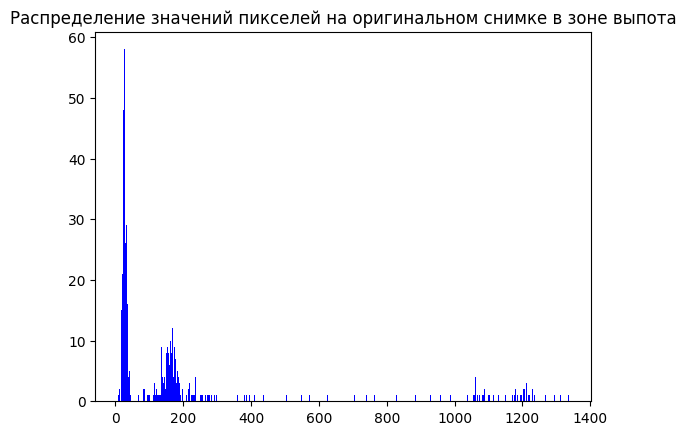

In [91]:
# Гистограмма распределения значений пикселей на оригинальном снимке в зоне выпота
plt.hist(cvet_np, bins=500, color='b', linewidth = 1) # параметр bins отвечает за количество подгрупп, в которые объединяются данные
plt.title('Распределение значений пикселей на оригинальном снимке в зоне выпота')
plt.show()

**Гистограмма распределения значений пикселей всего снимка**

In [92]:
print('\n','Новый тип переменной', type(np_orig))
print(' Размерность полученного массива', np_orig.shape)
print(' Размерность переменной', np_orig.dtype )


 Новый тип переменной <class 'numpy.ndarray'>
 Размерность полученного массива (512, 512)
 Размерность переменной int16


In [94]:
np_orig_1 = np_orig.reshape(262144)
np_orig_1.shape

(262144,)

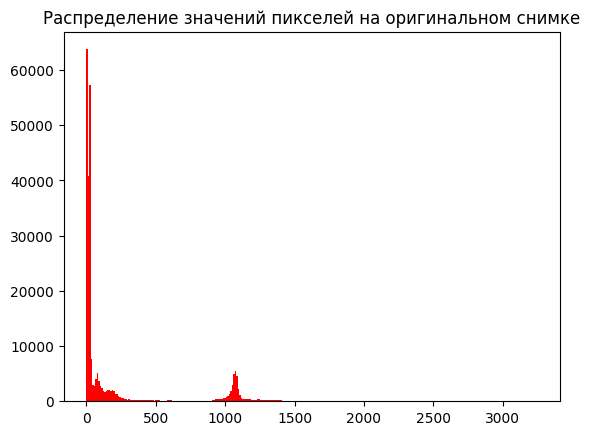

In [110]:
# Гистограмма распределения значений пикселей на оригинальном снимке в зоне выпота
plt.hist(np_orig_1, bins=300, color='r', linewidth = 1) # параметр bins отвечает за количество подгрупп, в которые объединяются данные
plt.title('Распределение значений пикселей на оригинальном снимке')
plt.show()

#**Оригинальный снимок без зоны выпота**

Не стал дальше делать. Не думаю что исключив 486 пикселей из общего количества в 262К мы визуально сможем оценить это исключение   

In [113]:
#  Проведем анализ слайса сегментированного выпота
x_list_o = []   # список х-координат (диапазон 1-512)
y_list_o = []   # список у-координат (диапазон 1-512)


for x in range (np_orig.shape[0]):    # запускаем счетчик по координате х
  for y in range (np_orig.shape[1]):  # запускаем счетчик по координате у
    x_list_o.append (x)              #
    y_list_o.append (y)              #
      #print (y,x)
print('Колчество пикселей выпота на слайсе =',len(x_list_o))
print('Сравниваем колчество позиций по х-',len(x_list_o), 'и у-', len(y_list_o))

Колчество пикселей выпота на слайсе = 262144
Сравниваем колчество позиций по х- 262144 и у- 262144


In [114]:
# Преобразуем списки х и у в np массив и добавим размерность
ox_np = np.array (x_list_o)
ox_np = ox_np.reshape(len(x_list_o),1)
print ('ox',ox_np.shape)

oy_np = np.array (y_list_o)
oy_np = oy_np.reshape(len(y_list_o),1)
print ('oy',oy_np.shape)

ox (262144, 1)
oy (262144, 1)


In [115]:
# Соберем координаты всех точек, имеющих признак выпото (по сегментации)
# в 2-у мерный массив со столбцами х-0, у-1
o_coordinates = np.append (ox_np, oy_np, axis=1)
#o_coordinates # массив с координатами выпота для данного слайса
o_coordinates.shape

(262144, 2)

In [ ]:
# Исключим из массива координат оригинального снимка зону с координатами выпота
#
#      1. Добавим к списку пациентов с выпотом список нестандартных файлов

Exclusion_list = []
Exclusion_list.extend(Effusions_list)
Exclusion_list.extend(Original_list_none)
print ('Количество пациентов в листе исключения: ', len(Exclusion_list))
print ('Срез списка пациентов в листе исключения: ', Exclusion_list[-6:])

#      2. Удалим из общего списка список, полученный в первом пункте.

healthy_list = [item for item in Original_list if item not in Exclusion_list]
print ('Количество здоровых пациентов для формирования x_train( на моем диске): ', len(healthy_list))
print ('Список здоровых пациентов для формирования x_train: ', healthy_list [-3:])